In [1]:
import torch
import torch.nn as nn
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

In [2]:
style_image = Image.open('abstract_style.jpg')
content_image = Image.open('content_image2.jpg')

Style Image Size -> (642, 476)


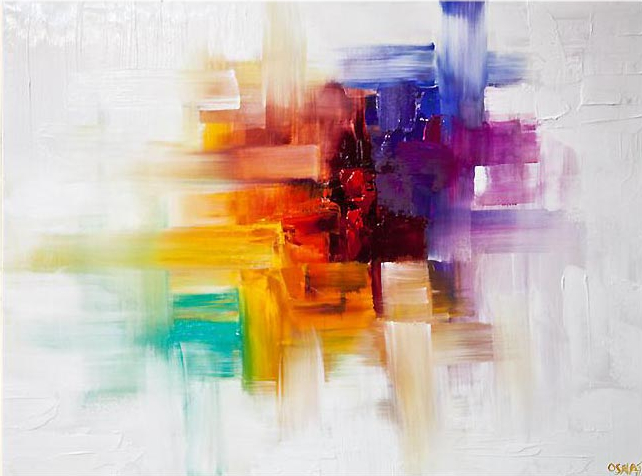

In [3]:
print('Style Image Size ->', style_image.size)
style_image

Content Image Size -> (959, 1280)


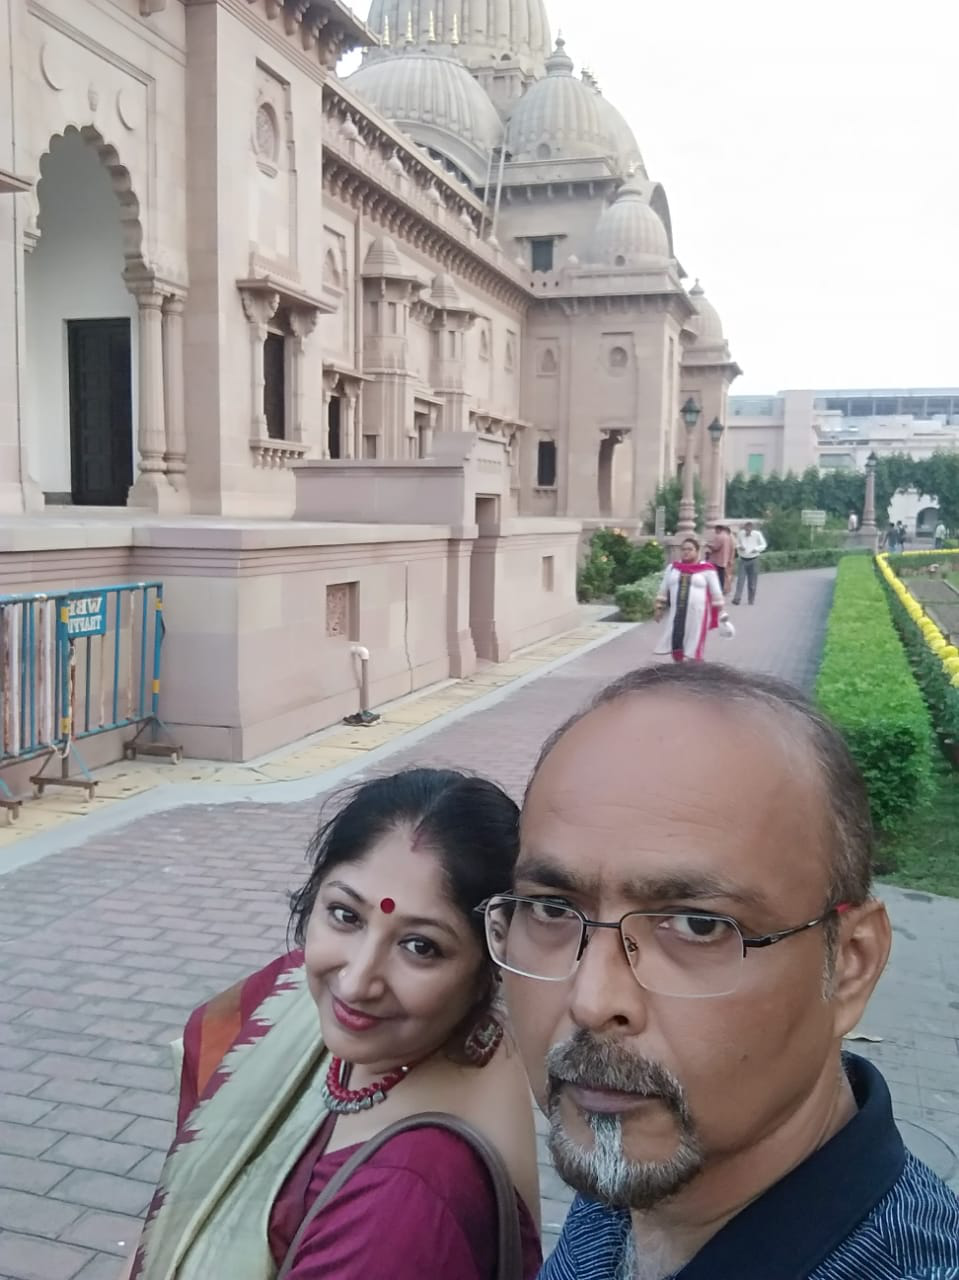

In [4]:
print('Content Image Size ->', content_image.size)
content_image

In [5]:
content_image = content_image.crop((0, 0, 950, 1280))
content_image.size

(950, 1280)

In [6]:
style_image = style_image.resize((760, 1024), Image.ANTIALIAS)#760, 1024
content_image = content_image.resize((760, 1024), Image.ANTIALIAS)#255, 320

Style Image Size -> (760, 1024)


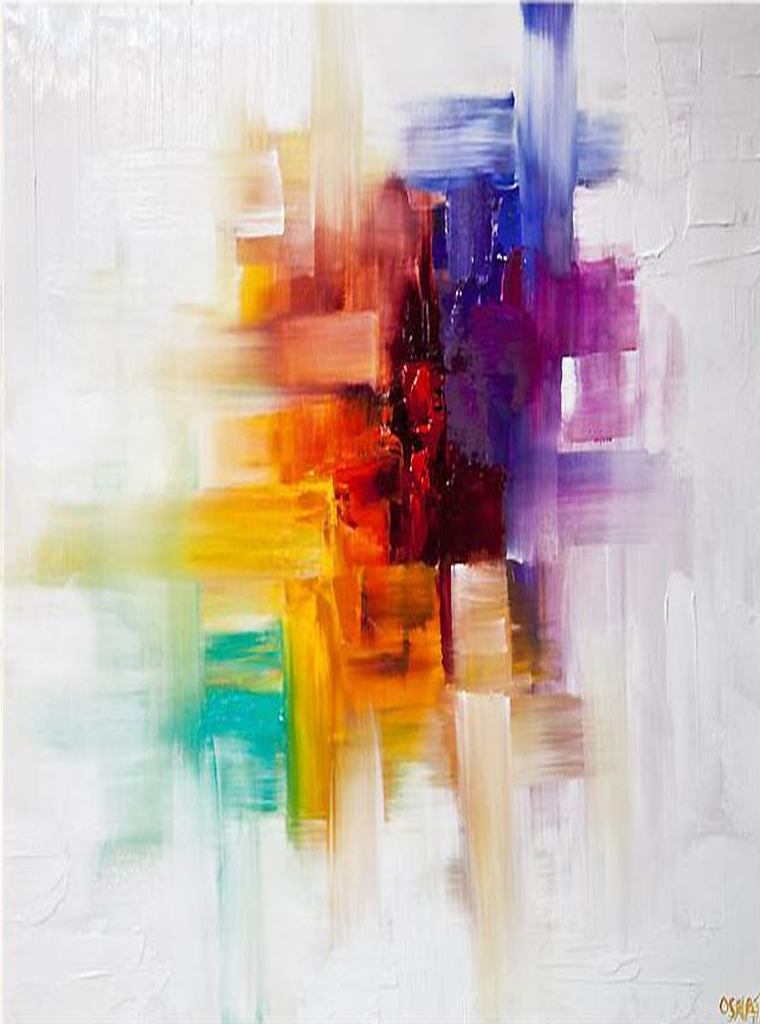

In [7]:
print('Style Image Size ->', style_image.size)
style_image

Content Image Size -> (760, 1024)


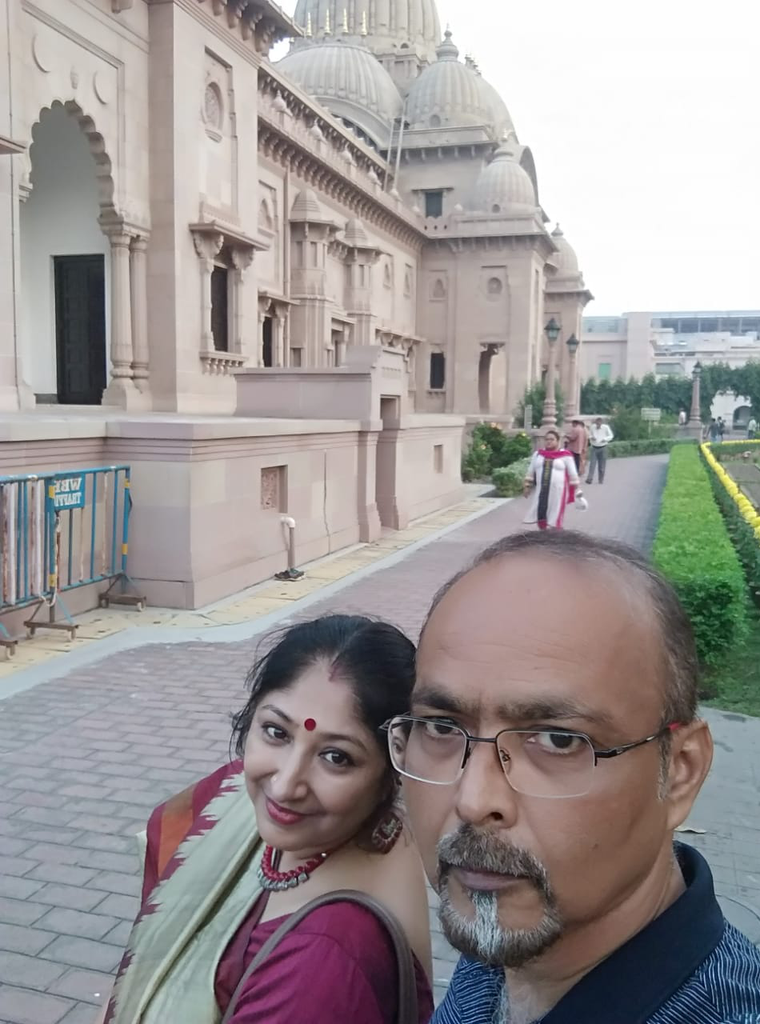

In [8]:
print('Content Image Size ->', content_image.size)
content_image

In [9]:
content_tensor = transforms.ToTensor()(content_image).to('cuda')
style_tensor = transforms.ToTensor()(style_image).to('cuda')

print('Content Tensor Shape ->', content_tensor.shape)
print('Style Tensor Shape ->  ', style_tensor.shape)
print()

# Adding batch dimension
content_tensor = content_tensor.unsqueeze(0)
style_tensor = style_tensor.unsqueeze(0)

print('Content Tensor Shape after adding new Dimension->', content_tensor.shape)
print('Style Tensor Shape after adding new Dimension->  ', style_tensor.shape)

Content Tensor Shape -> torch.Size([3, 1024, 760])
Style Tensor Shape ->   torch.Size([3, 1024, 760])

Content Tensor Shape after adding new Dimension-> torch.Size([1, 3, 1024, 760])
Style Tensor Shape after adding new Dimension->   torch.Size([1, 3, 1024, 760])


In [10]:
# generated_image_tensor = torch.randn(content_tensor.shape, device='cuda', requires_grad=True)
generated_image_tensor = content_tensor.clone().requires_grad_(True)

In [11]:
class VGGModel(nn.Module):
    def __init__(self):
        super(VGGModel, self).__init__()
        
        avg_pool_layers = [4, 9, 18, 27]
        self.style_layers = [0, 5, 10, 19, 28]
        self.content_layer = {'conv4_2': 21}
        self.model = vgg19(pretrained=True).features[:29]
        
        # Replace MaxPool with AvgPool
        for layer_num, layer in enumerate(self.model):
            if layer_num in avg_pool_layers:
                self.model[layer_num] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
    
    def forward(self, x):
        features = []

        for layer_num, layer in enumerate(self.model):
            x = layer(x)

            if layer_num == self.content_layer['conv4_2']:
                content = x
            if layer_num in self.style_layers:
                features.append(x)

        return features, content

In [12]:
model = VGGModel().to('cuda')

for param in model.parameters():
    param.requires_grad = False

In [13]:
epochs = 10000
lr = 0.001
alpha = 1
beta = 0.0000001
opt = torch.optim.Adam([generated_image_tensor], lr=lr)

for epoch in range(epochs):
    content_image_features, content_image_content = model(content_tensor)
    style_image_features, style_image_content = model(style_tensor)
    generated_image_features, generated_image_content = model(generated_image_tensor)
    
    content_loss = torch.mean(torch.square(content_image_content - generated_image_content))
    style_loss = 0
    
    for content_feature_layer, style_feature_layer, gen_feature_layer in zip(content_image_features, style_image_features, generated_image_features):
        

        _, channels, height, width = gen_feature_layer.shape
        G_gram_matrix = gen_feature_layer.view(channels, height*width).mm(gen_feature_layer.view(channels, height*width).t())
        S_gram_matrix = style_feature_layer.view(channels, height*width).mm(style_feature_layer.view(channels, height*width).t())

        style_loss += torch.mean(torch.square(S_gram_matrix - G_gram_matrix))
    
    total_loss = alpha*content_loss + beta*style_loss
    
    total_loss.backward()
    opt.step()
    opt.zero_grad()
    
    if (epoch+1) % 500 == 0:
        print('Loss -', total_loss.data)
        save_image(generated_image_tensor, 'out/generated'+str(epoch+1)+'.png')

Loss - tensor(0.3561, device='cuda:0')
Loss - tensor(0.1593, device='cuda:0')
Loss - tensor(0.1029, device='cuda:0')
Loss - tensor(0.0807, device='cuda:0')
Loss - tensor(0.0688, device='cuda:0')
Loss - tensor(0.0617, device='cuda:0')
Loss - tensor(0.0573, device='cuda:0')
Loss - tensor(0.0544, device='cuda:0')
Loss - tensor(0.0524, device='cuda:0')
Loss - tensor(0.0510, device='cuda:0')
Loss - tensor(0.0500, device='cuda:0')
Loss - tensor(0.0492, device='cuda:0')
Loss - tensor(0.0485, device='cuda:0')
Loss - tensor(0.0480, device='cuda:0')
Loss - tensor(0.0476, device='cuda:0')
Loss - tensor(0.0472, device='cuda:0')
Loss - tensor(0.0470, device='cuda:0')
Loss - tensor(0.0467, device='cuda:0')
Loss - tensor(0.0465, device='cuda:0')
Loss - tensor(0.0464, device='cuda:0')


In [ ]:
# transforms.ToPILImage()(generated_image_tensor.cpu().squeeze())

In [14]:
model

VGGModel(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pa

In [ ]:
4, 9, 18, 27

In [16]:
model.model[0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [31]:
model

VGGModel(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace=True)
    (18): AvgPo